<a href="https://colab.research.google.com/github/muratal49/NER-analysis-using-BiGRU/blob/main/NER_using_BIGRU_on_CoNLL2003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📌 **Introduction**

Named Entity Recognition (NER) is a core task in Natural Language Processing (NLP) that involves detecting and categorizing named entities such as **persons 🧑‍💼, organizations 🏢, locations 🌍, and miscellaneous entities 🔍** in text.

In this assignment, you will implement a **Bidirectional Gated Recurrent Unit (BiGRU) 🔄** model to perform NER on the **CoNLL-2003 dataset**. Unlike traditional sequence models (like CRFs or HMMs), **BiGRU captures both past and future contexts**, making it a powerful tool for sequence labeling tasks.

---

### 🎯 **Learning Objectives**

By the end of this assignment, you will:

✅ Understand the **CoNLL-2003 dataset** format and its annotation scheme.  
✅ Implement a **BiGRU-based model** for sequence labeling.  
✅ Apply **word embeddings** (e.g., GloVe, FastText) to improve model performance.  
✅ Use **PyTorch (or TensorFlow)** to train and evaluate your model.  
✅ Analyze **NER performance** and explore enhancements.  


---

### 🏆 **Task Description**

Your mission is to **develop a BiGRU-based NER model** by completing the following steps:

🔹 **Preprocess** the dataset: Convert words into numerical representations.  
🔹 **Build a BiGRU model** with word embeddings as input and entity labels as output.  
🔹 **Train the model** using an appropriate loss function (e.g., CrossEntropyLoss) and optimizer (e.g., Adam).  
🔹 **Evaluate** the model on the validation and test sets.  
🔹 **Analyze and improve**: Report key performance metrics (accuracy, F1-score) and suggest enhancements.

---


## 🎯 **Good Luck & Have Fun! 🚀**
🚀 Happy coding! If you have any questions, feel free to reach out. 🔥

---

# 🎯 **NLP Assignment: BiGRU for Named Entity Recognition (NER) on CoNLL-2003** 🚀


In [ ]:
import numpy as np
import pandas as pd
import random
import re

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [ ]:
!pip install datasets
!pip install seqeval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=4cf691fa4314533f5830cd7da47f43f7812ef221e87d572fde6fae01294cd2cf
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


💡 **Hint:**  
- We **strongly encourage** running this notebook on **Google Colab** for:  
  ✅ **Free GPU access** (L4, T4, or A100 for faster training).  
    - Training **one epoch on CPU** takes **approximately 5 minutes**.  
    - Training **one epoch on GPU (L4)** takes **only a few seconds**.  

  ✅ **Pre-installed packages**, reducing setup time.
  

In [ ]:
# Setting a seed makes results reproducible.

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

In [ ]:
# Check GPU availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


---

## 📂 **Dataset Overview**

The **CoNLL-2003 dataset** consists of sentences where each token is labeled using the **Inside-Outside-Beginning (IOB) tagging scheme**:


| Index | Tag        | Description                              | Example |
|-------|-----------|------------------------------------------|---------|
| 0     | **O** ❌  | Outside of any named entity             | `"This is a simple sentence."` |
| 1     | **B-LOC** 🏙️ | Beginning of a location entity     | `"I live in **[Paris]**(B-LOC)."` |
| 2     | **I-LOC** 🌍 | Inside a location entity         | `"I visited **[New York]**(B-LOC) **[City]**(I-LOC)."` |
| 3     | **B-PER** 👤 | Beginning of a person entity      | `"**[John]**(B-PER) Doe is a scientist."` |
| 4     | **I-PER** 🏅 | Inside a person entity           | `"**[Marie]**(B-PER) **[Curie]**(I-PER) discovered radium."` |
| 5     | **B-ORG** 🏛️ | Beginning of an organization entity | `"I work at **[Google]**(B-ORG)."` |
| 6     | **I-ORG** 🏢 | Inside an organization entity     | `"I work at **[United Nations]**(B-ORG) **[Headquarters]**(I-ORG)."` |




In [ ]:
# Load the CoNLL-2003 dataset
# Press 'y' to run the custom code
from datasets import load_dataset
dataset = load_dataset("conll2003")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

### Named Entity Types in CoNLL-2003

| **Tag** | **Meaning** | **Examples** |
|---------|------------|-------------|
| `PER`   | Person names | *John Smith, Albert Einstein* |
| `ORG`   | Organizations | *Google, United Nations* |
| `LOC`   | Locations | *New York, Europe* |
| `MISC`  | Miscellaneous entities | *Eiffel Tower, Grammy Awards* |


In [ ]:
#checking in the dataset:
dataset.keys()
dataset['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

- IT HAS 3 SPLITS.

In [ ]:
#A peak into a sample data:
dataset['train'][0]



{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

### CoNLL-2003 NER Tag Mappings (Hugging Face Datasets)

| **Number** | **Tag**    | **Description**                            |
|------------|-----------|--------------------------------------------|
| `0`        | `O`       | Outside any named entity                   |
| `1`        | `B-PER`   | Beginning of a Person entity               |
| `2`        | `I-PER`   | Inside a Person entity                     |
| `3`        | `B-ORG`   | Beginning of an Organization entity        |
| `4`        | `I-ORG`   | Inside an Organization entity              |
| `5`        | `B-LOC`   | Beginning of a Location entity             |
| `6`        | `I-LOC`   | Inside a Location entity                   |
| `7`        | `B-MISC`  | Beginning of a Miscellaneous entity        |
| `8`        | `I-MISC`  | Inside a Miscellaneous entity              |



### ✅ **Task: Sentence and Word Statistics**

Analyze the **basic structure of the dataset** by computing:
- **Total number of sentences** in the dataset (for each split).
- **Average sentence length** (number of words per sentence).
- **Maximum and minimum sentence lengths** to understand sequence length variation.

In [ ]:
# Total number of sentences in each split:
# print(f"Total number of sentences in the Train, Validation and Test respectively are:  ")
# len(dataset['train']), len(dataset['validation']), len(dataset['test'])


In [ ]:
#All in one..
#Counting number of average words per sentence and longest and shortest sentence token number:
splits = ['train', 'validation', 'test']

for split in splits:
    sentences = dataset[split]['tokens']  # Each item is a list of tokens (a sentence)

    sentence_lengths = [len(sentence) for sentence in sentences]  # Compute sentence lengths once
    total_words = sum(sentence_lengths)

    avg_words = total_words / len(sentences)
    longest_sentence = max(sentence_lengths)
    shortest_sentence = min(sentence_lengths)
    print(f'Number of sentences in {split} set {len(sentences)}')
    print(f'Average words in {split} set: {avg_words:.2f}')
    print(f'Longest sentence in {split} set: {longest_sentence} words')
    print(f'Shortest sentence in {split} set: {shortest_sentence} words')
    print("*" * 80)


Number of sentences in train set 14041
Average words in train set: 14.50
Longest sentence in train set: 113 words
Shortest sentence in train set: 1 words
********************************************************************************
Number of sentences in validation set 3250
Average words in validation set: 15.80
Longest sentence in validation set: 109 words
Shortest sentence in validation set: 1 words
********************************************************************************
Number of sentences in test set 3453
Average words in test set: 13.45
Longest sentence in test set: 124 words
Shortest sentence in test set: 1 words
********************************************************************************


### ✅ **Task: NER Tag Frequency Statistics**

1. **Compute the percentage distribution** of each tag.  
2. **Visualize the tag frequencies** using a **bar chart** for better insights.  


In [ ]:
import matplotlib.pyplot as plt

The tag frequency dist. of train set: 
 {3: 6321, 0: 169578, 7: 3438, 1: 6600, 2: 4528, 5: 7140, 4: 3704, 8: 1155, 6: 1157}
total number of tags in train set: 203621
The tag percentage dist. of train set: 
 {3: 3.1, 0: 83.28, 7: 1.69, 1: 3.24, 2: 2.22, 5: 3.51, 4: 1.82, 8: 0.57, 6: 0.57}


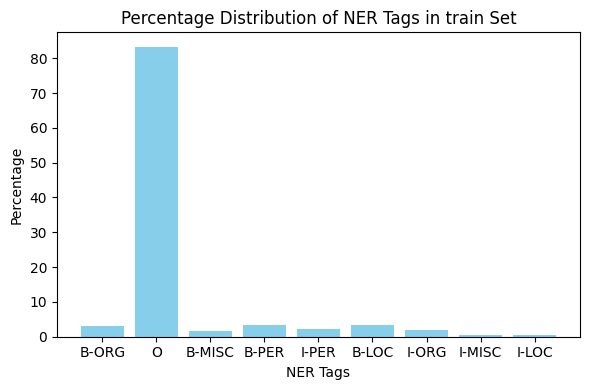

******************************************************************************** 

******************************************************************************** 

The tag frequency dist. of validation set: 
 {0: 42759, 3: 1341, 5: 1837, 7: 922, 8: 346, 1: 1842, 2: 1307, 6: 257, 4: 751}
total number of tags in validation set: 51362
The tag percentage dist. of validation set: 
 {0: 83.25, 3: 2.61, 5: 3.58, 7: 1.8, 8: 0.67, 1: 3.59, 2: 2.54, 6: 0.5, 4: 1.46}


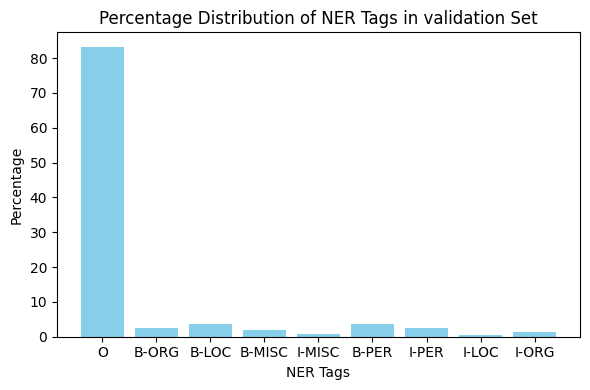

******************************************************************************** 

******************************************************************************** 

The tag frequency dist. of test set: 
 {0: 38323, 5: 1668, 1: 1617, 2: 1156, 6: 257, 7: 702, 8: 216, 3: 1661, 4: 835}
total number of tags in test set: 46435
The tag percentage dist. of test set: 
 {0: 82.53, 5: 3.59, 1: 3.48, 2: 2.49, 6: 0.55, 7: 1.51, 8: 0.47, 3: 3.58, 4: 1.8}


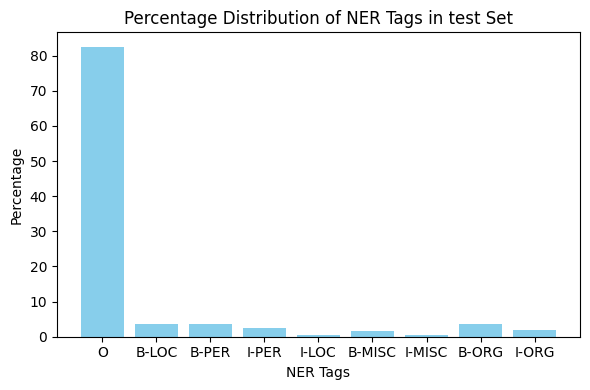

******************************************************************************** 

******************************************************************************** 



In [ ]:

# NER Tags:
tags = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# Initialize a dictionary to store tag counts by split
all_tag_counts = {}

for  split in splits:
    tag_counts = {}
    ner_tags = dataset[split]['ner_tags']

    # Counting tags for the current split
    for tag_values in ner_tags:
        for tag in tag_values:
            if tag in tag_counts:
                tag_counts[tag] += 1
            else:
                tag_counts[tag] = 1

    # Store the counts for the current split in the all_tag_counts dictionary
    all_tag_counts[split] = tag_counts

    # Print the final dictionary with tags counts
    print(f'The tag frequency dist. of {split} set: \n {tag_counts}')

    # Total number of tags in each split
    total_tags = sum(tag_counts.values())
    print(f'total number of tags in {split} set: {total_tags}')

    # Percent distribution
    for tag, count in tag_counts.items():
        tag_counts[tag] = round((count / total_tags) * 100, 2)
    print(f'The tag percentage dist. of {split} set: \n {tag_counts}')


    # Plotting bar
    plt.figure(figsize=(6, 4))

    # Map tags to dictionary keys
    tag_names = [tags[key] for key in tag_counts.keys()]
    values = list(tag_counts.values())

    plt.bar(tag_names, values, color='skyblue')

    plt.xlabel('NER Tags')
    plt.ylabel('Percentage')
    plt.title(f'Percentage Distribution of NER Tags in {split} Set')
    plt.tight_layout()
    plt.show()

    print("*" * 80, '\n')
    print("*" * 80, '\n')

# Now all_tag_counts holds the counts for each split, which can be used later



- In all splits the O tag is vert frequent as expected.  
We can see the tags only for a better understanding if we omit O in our plots.

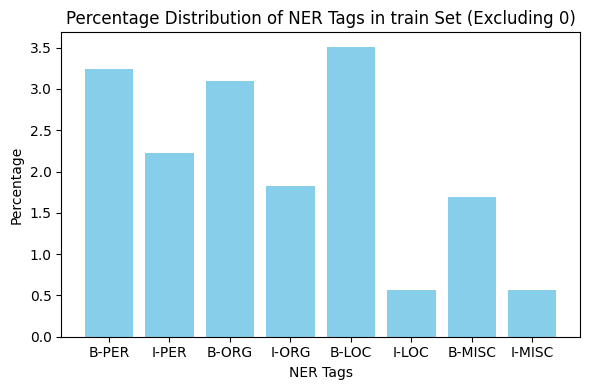

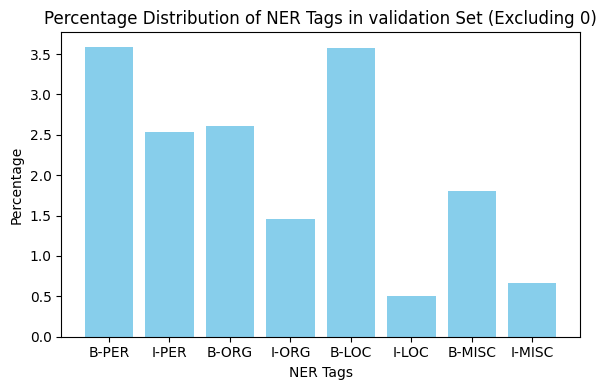

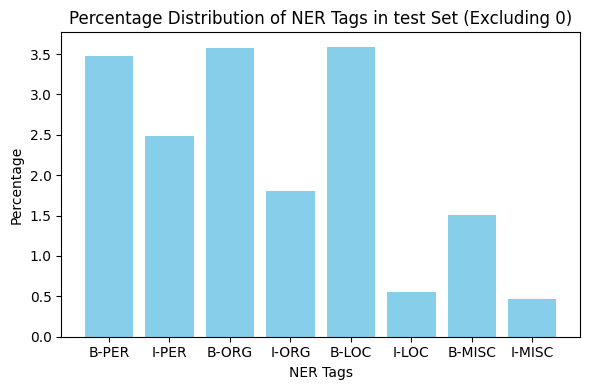

In [ ]:
#if we omit 0 key and plot:
# Plot everything except the 'O' tag
for split, tag_counts in all_tag_counts.items():
    # Remove the 'O' tag from the dictionary before plotting
    tag_counts = {tag: count for tag, count in tag_counts.items() if tag != 0}
    #sorting keys in ascending order:
    tag_counts = dict(sorted(tag_counts.items(), key=lambda item: item[0]))
    # Plot
    plt.figure(figsize=(6, 4))

    # Map tags to dictionary keys
    tag_names = [tags[key] for key in tag_counts.keys()]
    values = list(tag_counts.values())

    plt.bar(tag_names, values, color='skyblue')

    plt.xlabel('NER Tags')
    plt.ylabel('Percentage')
    plt.title(f'Percentage Distribution of NER Tags in {split} Set (Excluding 0)')
    plt.tight_layout()
    plt.show()


****

## **Data Preprocessing**



### ✅ **Task: Extract Unique Words and Tags**
- **Words** 📖: A set of all unique tokens in the **training** dataset.
- **Tags** 🏷️: A set of all unique NER labels in the **training** dataset.

***

In [ ]:
# TODO: Extract unique words and tags for vocab in the training dataset.
# HINT: Extract each token from every sentence
words = set()
for sentence in dataset['train']['tokens']:
    words.update(sentence)

# # HINT: Extract each NER tag from every label sequence
tags = set()
for label_seq in dataset['train']['ner_tags']:
    tags.update(label_seq)

In [ ]:
#see some elements from word
list(words)[:5]

['Roy', 'Seguy', 'desserts', 'challenge', '2467.872']

In [ ]:
tags

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [ ]:
# Create mappings
word2idx = {word: idx + 2 for idx, word in enumerate(words)}  # Start at 2 for padding & OOV
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1

# Define CoNLL-2003 NER tags
NER_TAGS = [
    "O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"
]


### ✅ **Task: Create Tag-to-Index and Index-to-Tag Mappings**
Fill in the missing code to:
- **Convert tag names** into unique numerical indices (`tag2idx`).
- **Convert indices back** to tag names (`idx2tag`).
***


In [ ]:
# TODO: Map tag names to indices and vice versa
# HINT: Assign a unique index to each tag
tag2idx = {}
for i,tag in enumerate(NER_TAGS):
    tag2idx[tag] = i
# HINT: Reverse the mapping for decoding
idx2tag = {}
for i,tag in enumerate(NER_TAGS):
    idx2tag[i] = tag

In [ ]:
tag2idx

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

### ✅ **Task: Categorize Capitalization Features**  

💡 **Hints & Explanations**  

#### **Why Use Capitalization Features?**  
- Named entities often follow **capitalization patterns** (e.g., **ALL_CAPS** for organizations, **First_Capitalized** for names).  
- Including capitalization features **improves NER performance** by helping the model recognize entity types more effectively.  

***

In [ ]:
# TODO: Define a function to categorize capitalization types
def get_capitalization_feature(word):

    # HINT: Check if the word is in ALL CAPS
    # Added {2,} to make sure it does not take all single capital letters as an organization names.
    if re.search('^[A-Z]{2,}$', word) != None:
        return 1

    # HINT: Check if only the first letter is capitalized (Title Case)
    elif re.search('^[A-Z][a-z]*$',word)!=None:
        return 2

    # HINT: Check if the word is entirely lowercase
    elif re.search('^[a-z]+$', word) != None:
        return 3

    # HINT: Check if there are uppercase letters after the first character (Mixed Case)

    elif re.search('^[a-z]+[A-Z]+[a-z]*$', word) != None:

        return 4

    # If none of the above, assign Only_One_Capital category
    else:
        return 5

In [ ]:
CAPITALIZATION_TAGS = ["ALL_CAPS", "First_Capitalized", "all_lowercase", "Mixed_Case", "Only_One_Capital"]

# TODO: Define a mapping for capitalization categories
# HINT: Assign a unique index to each capitalization category, starting from 1
cap2idx = {}
for i,cap in enumerate(CAPITALIZATION_TAGS):
    cap2idx[cap] = i+1

cap2idx["<PAD>"] = 0

***
## **Dataset Preparation and Dynamic Batching**


### ✅ **Task: Complete `__getitem__` to Return Encoded Tokens and Labels**
Fill in the missing code to:
- Convert **words into numerical indices** using `word2idx`.
- Convert **NER labels into numerical indices** (they are already numeric in the dataset).

***

In [ ]:
# Custom Dataset Class for NER
class NERDataset(Dataset):
    def __init__(self, data):
        self.sentences = data["tokens"]  # List of tokenized sentences
        self.labels = data["ner_tags"]   # Corresponding NER labels

    def __len__(self):
        return len(self.sentences)  # Return the total number of sentences

    def __getitem__(self, idx):
        # TODO: Implement data retrieval for a single example
        # HINT: Extract the tokens of the sentence at index `idx`
        words = self.sentences[idx]
        # HINT: Extract the corresponding NER labels
        labels = self.labels[idx]

        # HINT: Convert words to indices
        word_ids = [word2idx.get(word, word2idx["<UNK>"]) for word in words]
        # HINT: Convert words to Capitalization Features
        cap_features = [get_capitalization_feature(word) for word in words]

        # NER labels are already in numeric format
        label_ids = labels

        return torch.tensor(word_ids),  torch.tensor(cap_features), torch.tensor(label_ids)



### ✅ **Task: Complete `collate_fn` to Pad Batches Properly**


When using **PyTorch's DataLoader**, we need a custom `collate_fn` to:
- **Batch variable-length sequences** by **padding** them to the same length.
- Ensure that **words and labels are padded correctly**.
- Move the tensors to the **correct device (GPU/CPU)**.

Fill in the missing code to:
- Use `pad_sequence` to pad **word tensors** and **label tensors**.
- Ensure `<PAD>` is used for words and `-100` is used for labels (ignored in loss computation).
- Move tensors to `DEVICE`.

***


In [ ]:
# TODO: Implement collate_fn for dynamic batching
def collate_fn(batch):
    words, cap_features, labels = zip(*batch)

 # HINT: Pad words using "<PAD>"
    words_padded = pad_sequence(
        [torch.tensor(word_ids) for word_ids in words],
        batch_first=True,
        padding_value=word2idx["<PAD>"]  # Padding with <PAD> index
    )

    # HINT: Pad capitalization features using "<PAD>"
    cap_padded = pad_sequence(
        [torch.tensor(cap_feature) for cap_feature in cap_features],
        batch_first=True,
        padding_value=word2idx["<PAD>"] # Padded with "PAD"
    )

    # HINT: Use `-100` for ignored label padding
    labels_padded = pad_sequence(
        [torch.tensor(label) for label in labels],
        batch_first=True,
        padding_value=-100  # Padding value for labels (usually -100 for ignored labels)
    )

    return words_padded.to(DEVICE), cap_padded.to(DEVICE), labels_padded.to(DEVICE)


In [ ]:
train_dataset = NERDataset(dataset["train"])
val_dataset = NERDataset(dataset["validation"])
test_dataset = NERDataset(dataset["test"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

***

## **BiGRU Implementation**



### ✅ **Task: Complete two embedding layers and the `forward` method**


### 📌 **Overview**
The `BiGRU_NER` model combines **word embeddings** and **capitalization features** to enhance named entity recognition (NER) performance. It processes input sequences using **Bidirectional GRUs** and predicts entity tags for each token.

The `forward` method defines how the **BiGRU-based NER model** processes input data.  
It consists of **three main steps**:
1. Convert **word indices into dense embeddings** using `nn.Embedding`.
2. Pass the embeddings through a **BiGRU** to capture sequential dependencies.
3. Apply a **fully connected layer (`fc`)** to map GRU outputs to entity tag predictions.


***

In [ ]:
class BiGRU_NER(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=300, hidden_dim=256, num_layers=2, cap_embedding_dim=8):
        super(BiGRU_NER, self).__init__()

        # TODO: Initialize word embedding layer
        # HINT: Maps words to dense vector representations.
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim=embedding_dim, padding_idx=word2idx["<PAD>"])

        # TODO: Initialize capitalization feature embedding layer
        # HINT: Maps capitalization types to dense vectors for feature enhancement.
        self.cap_embedding = nn.Embedding(len(cap2idx), embedding_dim=cap_embedding_dim, padding_idx=cap2idx["<PAD>"])

        input_dim = embedding_dim + cap_embedding_dim  # Combine word and capitalization features
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=True, batch_first=True, dropout=0.3)

        self.fc = nn.Linear(hidden_dim * 2, tagset_size)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    def forward(self, word_ids, cap_features):
        # TODO: Convert word indices to embeddings
        word_embeds = self.word_embedding(word_ids)

        # TODO: Convert capitalization features to embeddings
        cap_embeds = self.cap_embedding(cap_features)

        # TODO: Concatenate word embeddings with capitalization embeddings along the last dimension
        combined_input = torch.cat((word_embeds, cap_embeds), dim=-1)

        # TODO: Pass the concatenated embeddings through the BiGRU
        gru_out, _ = self.gru(combined_input)

        output = self.fc(gru_out)

        return output  # Shape: (batch_size, seq_length, tagset_size)

***

## **Training and evaluation**



### ✅ **Task: Complete the `train_model` and the `validate_model` functions**  

#### 📌 **Overview**
The **training loop** is a crucial component of the BiGRU NER model. It performs **gradient-based optimization** to improve the model's ability to recognize named entities. During training, the model learns **patterns in word embeddings and capitalization features**, refining its predictions over multiple epochs.

This section guides you through implementing the **training and validation pipeline**.


In [ ]:
import matplotlib.pyplot as plt

# 🏋️‍♂️ TODO: Implement Training Loop for BiGRU NER Model
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4, save_path="best_bigru_ner.pth",
                 print_loss=False, plot_loss=True):
    """
    Train a BiGRU-based Named Entity Recognition (NER) model.

    Args:
        model (nn.Module): The BiGRU NER model.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of training epochs (default=10).
        learning_rate (float): Learning rate for optimizer (default=1e-4).
        save_path (str): Path to save the best model (default="best_bigru_ner.pth").
    """

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padding tokens in loss computation

    best_val_loss = float("inf")

    train_losses = []
    val_losses = []

    # 🔄 Main Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for word_ids, cap_features, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            optimizer.zero_grad()  # Reset gradients before backpropagation

            # TODO: Forward Pass
            # HINT: Get model predictions (shape: [batch_size, seq_length, num_tags])
            outputs = model(word_ids, cap_features)

            # Reshape Outputs and Labels for Loss Calculation
            outputs = outputs.view(-1, outputs.shape[-1])  # Flatten predictions to [total_tokens, num_tags]
            labels = labels.view(-1)  # Flatten labels to [total_tokens]

            # Compute loss
            loss = loss_fn(outputs, labels)  # Calculate cross-entropy loss

            # TODO: Backpropagation and Optimization
            # HINT: Compute gradients
            loss.backward()
            # HINT: Update model parameters
            optimizer.step()
            total_train_loss += loss.item()  # Track training loss

        # Compute average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)

        # Validate Model Performance on Validation Set
        avg_val_loss = validate_model(model, val_loader, loss_fn)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if print_loss:
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # TODO: Save Best Model Based on Validation Loss
        if avg_val_loss < best_val_loss:
            # HINT: Update best validation loss
            best_val_loss = avg_val_loss
            # HINT: Save model weights
            torch.save(model.state_dict(), save_path)
            if print_loss:
                print("Best model saved!")  # Indicate model update

    if plot_loss:
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
        plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="s")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()


def validate_model(model, val_loader, loss_fn):
    """
    Evaluate the model on validation data.

    Args:
        model (nn.Module): The trained BiGRU model.
        val_loader (DataLoader): DataLoader for validation data.
        loss_fn (nn.CrossEntropyLoss): Loss function used for evaluation.

    Returns:
        float: Average validation loss.
    """
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for word_ids, cap_features, labels in val_loader:
            # TODO: Forward Pass
            # HINT: Get model predictions (shape: [batch_size, seq_length, num_tags])
            outputs = model(word_ids, cap_features)

            # Reshape Outputs and Labels for Loss Calculation
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            # Compute validation loss
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()

    return total_val_loss / len(val_loader)

### ✅ **Task: Complete the `test_model` function**  

#### 📌 **Overview**
Once the BiGRU NER model is trained, we need to **evaluate its performance** on the **test set**.  
This step ensures that the model generalizes well to unseen data. The evaluation consists of:

1. **Loading the Best Model Weights**  
   - We retrieve the saved model from training and set it to **evaluation mode**.

2. **Making Predictions**  
   - The model processes input sentences and predicts NER tags.

3. **Computing the Test Loss**  
   - We measure how well the model performs by computing the **cross-entropy loss**.

4. **Mapping Predictions to NER Tags**  
   - Convert **predicted class indices** to their corresponding **NER tags**.

5. **Generating Performance Metrics**  
   - Compute **precision, recall, and F1-score** using `classification_report()`.

***


In [ ]:
# 🛠️ TODO: Implement Model Testing with Evaluation Metrics
def test_model(model, test_loader, loss_fn, model_path="best_bigru_ner.pth"):
    """
    Evaluate the trained BiGRU NER model on the test set.

    Args:
        model (nn.Module): The trained BiGRU model.
        test_loader (DataLoader): DataLoader for test data.
        loss_fn (nn.CrossEntropyLoss): Loss function for evaluation.
        model_path (str): Path to the saved best model.

    Returns:
        None (Prints test performance and metrics)
    """

    print("Loading best model for testing...")

    # TODO: Load Pretrained Model Weights
    # HINT: Load the best model

    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    model.eval()

    total_test_loss = 0
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for word_ids, cap_features, labels  in test_loader:
            outputs = model(word_ids, cap_features)  # Forward pass

            # Compute test loss
            loss = loss_fn(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            total_test_loss += loss.item()

            # Convert Logits to Predicted Class Indices
            predictions = outputs.argmax(dim=-1).cpu().numpy()
            labels = labels.cpu().numpy()

            for i in range(len(labels)):
                # TODO: Convert Index Predictions to Tag Names
                # HINT: Convert label indices to NER tags, ignoring padding tokens (-100)
                true_labels.append([idx2tag[label] for label in labels[i] if label != -100])
                # HINT: Ensure we only consider predicted tags where the original label is not padding (-100)
                pred_labels.append([idx2tag[pred] for pred, label in zip(predictions[i], labels[i]) if label != -100])

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")

    print("\nTest Set Performance:")
    # ⚠️ Keep this import unchanged, otherwise (sklearn.metrics) evaluation defaults to token level
    from seqeval.metrics import classification_report
    print(classification_report(true_labels, pred_labels))

Epoch 1/10:   0%|          | 0/439 [00:00<?, ?it/s]<ipython-input-23-625baebd4f8b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(word_ids) for word_ids in words],
<ipython-input-23-625baebd4f8b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(cap_feature) for cap_feature in cap_features],
<ipython-input-23-625baebd4f8b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(label) for label in labels],
Epoch 10/10: 100%|██████████| 439/439 [00:06<00:00, 70.72it/s]


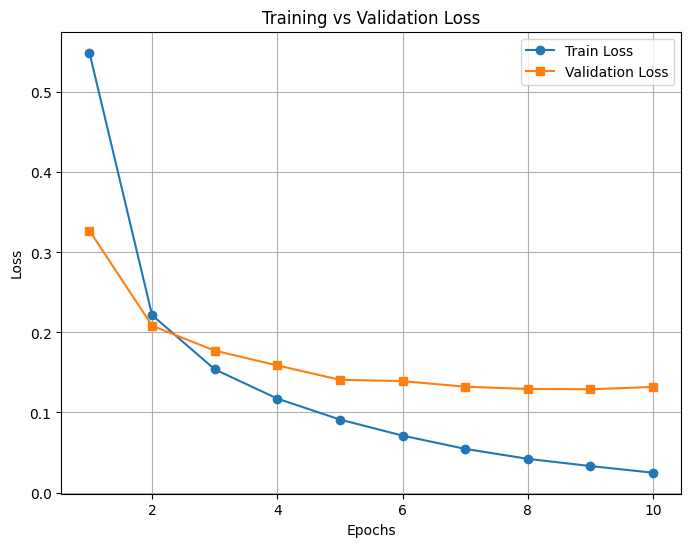

Loading best model for testing...


NameError: name 'save_path' is not defined

In [ ]:
from sklearn.metrics import classification_report

# Initialize model and run training
model = BiGRU_NER(len(word2idx), len(tag2idx),hidden_dim=256).to(DEVICE)

# Train model and select best parameters using validation set
train_model(model, train_loader, val_loader, num_epochs=10)


In [ ]:

# Test model using best saved parameters
test_model(model, test_loader, nn.CrossEntropyLoss(ignore_index=-100))

Loading best model for testing...


<ipython-input-31-470d4c2d6e3d>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
<ipython-input-23-625baebd4f8b>:7: UserWarnin

Test Loss: 0.2174

Test Set Performance:
              precision    recall  f1-score   support

         LOC       0.85      0.76      0.80      1668
        MISC       0.62      0.62      0.62       702
         ORG       0.70      0.65      0.67      1661
         PER       0.74      0.81      0.77      1617

   micro avg       0.74      0.73      0.73      5648
   macro avg       0.73      0.71      0.72      5648
weighted avg       0.75      0.73      0.73      5648



***
## **Introduction to GloVe (glove-wiki-gigaword-300) Word Embeddings**





### 📌 **What is GloVe?**
**GloVe (Global Vectors for Word Representation)** is a **pre-trained word embedding model** developed by **Stanford NLP**. Unlike **Word2Vec**, which is based on a predictive model, GloVe is a **count-based model** that captures global word co-occurrence statistics from large text corpora.

## 📥 **About `glove-wiki-gigaword-300`**
The **glove-wiki-gigaword-300** model is a **300-dimensional GloVe embedding** trained on the **Wikipedia 2014 + Gigaword 5 corpus**, which consists of **6 billion tokens**. This pre-trained embedding provides dense vector representations for **400,000 unique words**.

### 📊 **Model Details**
| Feature | Value |
|---------|-------|
| **Name** | `glove-wiki-gigaword-300` |
| **Corpus** | Wikipedia 2014 + Gigaword 5 |
| **Vocabulary Size** | ~400,000 words |
| **Embedding Dimension** | 300 |
| **Total Training Tokens** | ~6 billion |

## 🚀 **Why Use GloVe for NER?**
Using **pre-trained embeddings like GloVe** in NER tasks can **improve model performance** by providing:  
✅ **Semantic Information** – Words with similar meanings have similar vector representations.  
✅ **Better Generalization** – Helps the model learn even with **limited training data**.  
✅ **Faster Convergence** – Pre-trained embeddings reduce the amount of training required.  

## 🏗️ **How to Load GloVe in Python?**
We use the **`gensim.downloader` API** to easily load GloVe embeddings:

In [ ]:
import gensim.downloader as api

# Load Pre-Trained GloVe Embeddings
glove_model = api.load("glove-wiki-gigaword-300")
embedding_dim = 300

[==================================================] 100.0% 376.1/376.1MB downloaded


### ✅ **Task: Complete the `Embedding Matrix` Initialization**

#### 📌 **Overview**
Before training our **BiGRU-based NER model** with Glove, we need to **initialize the embedding matrix**.  
The embedding matrix stores **word representations**, which help the model understand **semantic relationships** between words.

This step ensures that words in our dataset are mapped to **pre-trained GloVe vectors** for better generalization.


In [ ]:
# 🏗️ TODO: Initialize Embedding Matrix
# Create a zero matrix of shape (vocab_size, embedding_dim)
embedding_matrix = torch.zeros(len(word2idx), embedding_dim)

for word, idx in word2idx.items():
    if word in glove_model:
        # HINT: Assign the corresponding GloVe vector to the word’s index in the embedding matrix
        vector=glove_model[word]
        embedding_matrix[idx] = torch.tensor(vector)

### ✅ **Task: Update the `BiGRU_NER` Class for Pre-trained Embeddings**  

In [ ]:
class BiGRU_NER(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_matrix, embedding_dim=300, hidden_dim=256, num_layers=2, cap_embedding_dim=8):
        super(BiGRU_NER, self).__init__()

        # TODO: Initialize Embedding Layer (Random or Pre-trained)
        if embedding_matrix is None:
            # Copy and paste the forward method implementation from the earlier model definition.
            self.word_embedding = nn.Embedding(vocab_size, embedding_dim=embedding_dim, padding_idx=word2idx["<PAD>"])

        else:
            # HINT: Load pre-trained embeddings (e.g., GloVe) and allow fine-tuning (`freeze=False`).
            self.word_embedding= nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        # TODO: Initialize capitalization feature embedding layer
        # Copy and paste the forward method implementation from the earlier model definition.
        self.cap_embedding = nn.Embedding(len(cap2idx), embedding_dim=cap_embedding_dim, padding_idx=cap2idx["<PAD>"])

        input_dim = embedding_dim + cap_embedding_dim  # Combine word and capitalization features
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=True, batch_first=True, dropout=0.3)

        self.fc = nn.Linear(hidden_dim * 2, tagset_size)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    def forward(self, word_ids, cap_features):
        # TODO: Implement forward pass for BiGRU_NER
        # Copy and paste the forward method implementation from the earlier model definition.

        word_embeds = self.word_embedding(word_ids)


        cap_embeds = self.cap_embedding(cap_features)


        combined_input = torch.cat((word_embeds, cap_embeds), dim=-1)

        gru_out, _ = self.gru(combined_input)

        output = self.fc(gru_out)



        return output  # Shape: (batch_size, seq_length, tagset_size)

Epoch 1/10:   0%|          | 0/439 [00:00<?, ?it/s]<ipython-input-23-625baebd4f8b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(word_ids) for word_ids in words],
<ipython-input-23-625baebd4f8b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(cap_feature) for cap_feature in cap_features],
<ipython-input-23-625baebd4f8b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(label) for label in labels],
Epoch 10/10: 100%|██████████| 439/439 [00:06<00:00, 72.76it/s]


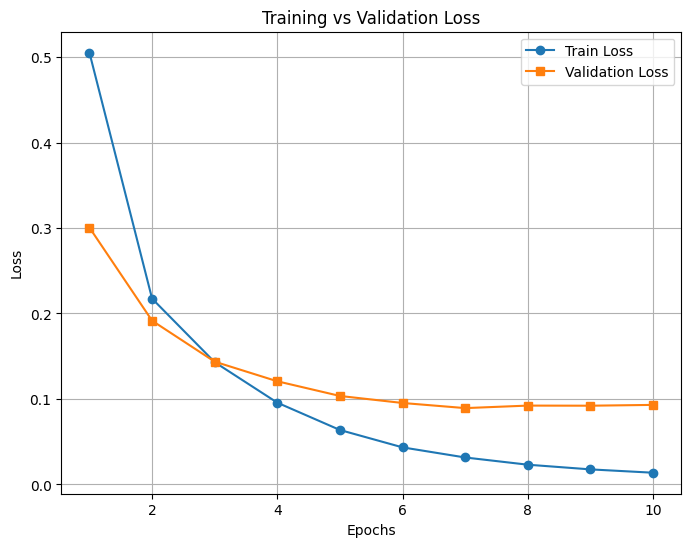

Loading best model for testing...


<ipython-input-31-470d4c2d6e3d>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Loss: 0.1635

Test Set Performance:
              precision    recall  f1-score   support

         LOC       0.88      0.85      0.86      1668
        MISC       0.59      0.67      0.63       702
         ORG       0.70      0.77      0.73      1661
         PER       0.85      0.83      0.84      1617

   micro avg       0.78      0.80      0.79      5648
   macro avg       0.76      0.78      0.77      5648
weighted avg       0.78      0.80      0.79      5648



In [ ]:
pretrained_emb_model = BiGRU_NER(len(word2idx), len(tag2idx), embedding_matrix).to(DEVICE)

train_model(pretrained_emb_model, train_loader, val_loader, num_epochs=10)

test_model(pretrained_emb_model, test_loader, nn.CrossEntropyLoss(ignore_index=-100))

***

# 🔬 **Ablation Study: Impact of Capitalization Features on NER Performance**




## 📌 **Objective**
The goal of this ablation study is to **analyze the effect of capitalization features** on Named Entity Recognition (NER) performance. By removing capitalization embeddings and comparing results, we can determine whether capitalization plays a significant role in improving entity recognition.


##  **Experimental Setup**
We will conduct two experiments:
1. **With Capitalization Features (Baseline Model)**  
   - The model uses both **word embeddings** and **capitalization embeddings**.
   - Capitalization features are encoded using a separate embedding layer.
   - Input to BiGRU = **Word Embeddings + Capitalization Embeddings**.

2. **Without Capitalization Features (Ablated Model)**  
   - The model **only uses word embeddings** (removes capitalization embeddings).
   - Input to BiGRU = **Only Word Embeddings**.

---

## 📌 **Objective**
In this task, you will implement a **BiGRU-based NER model without capitalization features** (`BiGRU_NER_NoCap`).  
This model will serve as a **baseline** in our ablation study to determine the impact of capitalization features on NER performance.

---


### ✅ **Task: Implement the `forward` Method**
- **Process input word indices** through the embedding layer.  
- **Pass embeddings through BiGRU** to generate contextualized token representations.  
- **Apply the fully connected layer (`fc`)** to get final NER predictions.  
- **Ignore `cap_features`**:  

In [ ]:
class BiGRU_NER_NoCap(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_matrix=None, embedding_dim=300, hidden_dim=256, num_layers=2):
        super(BiGRU_NER_NoCap, self).__init__()

        # TODO: Initialize Embedding Layer (Random or Pre-trained)
        # Copy and paste the forward method implementation from the earlier model definition.
        if embedding_matrix is None:
            self.word_embedding = nn.Embedding(vocab_size, embedding_dim=embedding_dim, padding_idx=word2idx["<PAD>"])

        else:
            self.word_embedding= nn.Embedding.from_pretrained(embedding_matrix, freeze=False)


        # Input to BiGRU is only word embeddings
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          bidirectional=True, batch_first=True, dropout=0.3)

        self.fc = nn.Linear(hidden_dim * 2, tagset_size)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    def forward(self, word_ids, cap_features):
        # TODO: Implement forward pass for BiGRU_NER_NoCap
        # There’s no need to use cap_features in this function.
        # It is included as a parameter only to maintain consistency with the training logic.
        word_embeds = self.word_embedding(word_ids)

        gru_out, _ = self.gru(word_embeds)

        output = self.fc(gru_out)

        return output

Epoch 1/10:   0%|          | 0/439 [00:00<?, ?it/s]<ipython-input-23-625baebd4f8b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(word_ids) for word_ids in words],
<ipython-input-23-625baebd4f8b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(cap_feature) for cap_feature in cap_features],
<ipython-input-23-625baebd4f8b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(label) for label in labels],
Epoch 10/10: 100%|██████████| 439/439 [00:06<00:00, 67.02it/s]


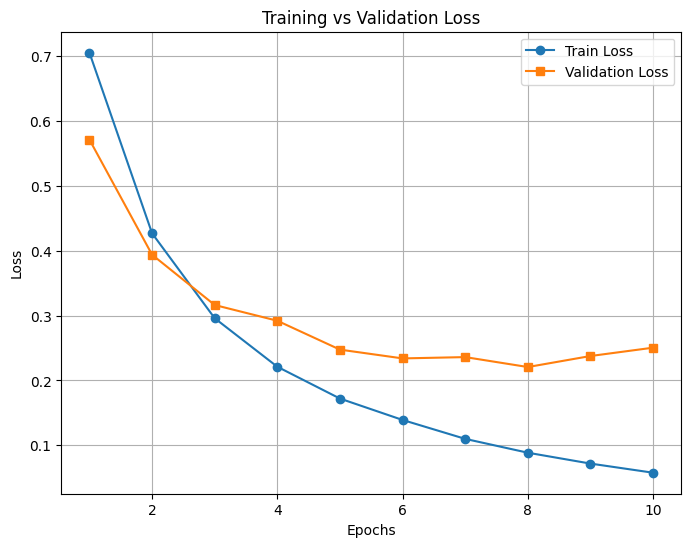

Loading best model for testing...


<ipython-input-31-470d4c2d6e3d>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Loss: 0.3217

Test Set Performance:
              precision    recall  f1-score   support

         LOC       0.90      0.55      0.68      1668
        MISC       0.69      0.49      0.57       702
         ORG       0.58      0.56      0.57      1661
         PER       0.68      0.58      0.62      1617

   micro avg       0.69      0.55      0.61      5648
   macro avg       0.71      0.54      0.61      5648
weighted avg       0.72      0.55      0.62      5648



In [ ]:
model_no_cap = BiGRU_NER_NoCap(len(word2idx), len(tag2idx)).to(DEVICE)

train_model(model_no_cap, train_loader, val_loader)

test_model(model_no_cap, test_loader, nn.CrossEntropyLoss(ignore_index=-100))

Epoch 1/10:   0%|          | 0/439 [00:00<?, ?it/s]<ipython-input-23-625baebd4f8b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(word_ids) for word_ids in words],
<ipython-input-23-625baebd4f8b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(cap_feature) for cap_feature in cap_features],
<ipython-input-23-625baebd4f8b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(label) for label in labels],
Epoch 10/10: 100%|██████████| 439/439 [00:05<00:00, 73.62it/s]


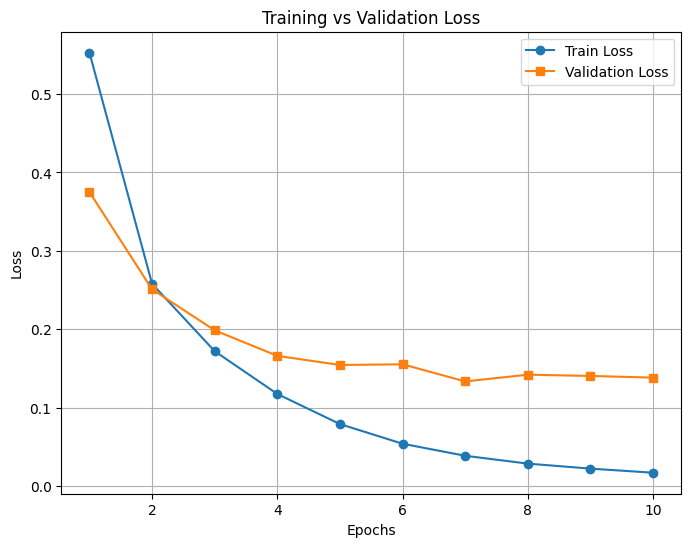

Loading best model for testing...


<ipython-input-31-470d4c2d6e3d>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Loss: 0.2077

Test Set Performance:
              precision    recall  f1-score   support

         LOC       0.83      0.73      0.78      1668
        MISC       0.48      0.63      0.55       702
         ORG       0.68      0.70      0.69      1661
         PER       0.77      0.75      0.76      1617

   micro avg       0.71      0.71      0.71      5648
   macro avg       0.69      0.70      0.69      5648
weighted avg       0.73      0.71      0.72      5648



In [ ]:
pretrained_emb_model_no_cap = BiGRU_NER_NoCap(len(word2idx), len(tag2idx), embedding_matrix).to(DEVICE)

train_model(pretrained_emb_model_no_cap, train_loader, val_loader)

test_model(pretrained_emb_model_no_cap, test_loader, nn.CrossEntropyLoss(ignore_index=-100))